In [4]:

import sys, subprocess

def ensure(pkg_import_name, pip_name=None):
    pip_name = pip_name or pkg_import_name
    try:
        __import__(pkg_import_name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name])


ensure("numpy", "numpy")
ensure("tensorflow", "tensorflow")          
ensure("sklearn", "scikit-learn")
ensure("matplotlib", "matplotlib")
ensure("pandas", "pandas")
ensure("IPython", "ipython")


try:
    ensure("xgboost", "xgboost")
except Exception:
    print("xgboost could not be installed; code will use GradientBoostingClassifier as fallback.")


In [5]:
import os, random, warnings, math
from pathlib import Path
warnings.filterwarnings("ignore")


desired_path = Path("C:/Users/qxz3g7a/PycharmProjects/MIT-Projects/cos801/assignment 1/data")
os.chdir(desired_path)

import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    XGB_AVAILABLE = False
    print("xgboost not found; using GradientBoostingClassifier as the fallback.")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


SEED = 123
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)



ROOT       = os.getcwd()

TRAIN_DIR  = os.path.join(ROOT, "train/train")
VAL_DIR    = None       
TEST_DIR   = os.path.join(ROOT, "test/test")   
USE_SPLIT  = True       
IMG_SIZE   = 256
BATCH_SIZE = 20
EPOCHS     = 25
AUTOTUNE   = tf.data.AUTOTUNE


CLASS_NAMES = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen",
    "Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse",
    "Small-flowered Cranesbill","Sugar beet"
]
print(f"TensorFlow: {tf.__version__}")
print('root is', ROOT)
print('training dir', TRAIN_DIR)

TensorFlow: 2.19.0
root is C:\Users\qxz3g7a\PycharmProjects\MIT-Projects\cos801\assignment 1\data
training dir C:\Users\qxz3g7a\PycharmProjects\MIT-Projects\cos801\assignment 1\data\train/train


In [6]:
def list_class_folders(root, allowed):
    found = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if os.path.isdir(p) and d in allowed:
            found.append(d)
    if not found:
        raise RuntimeError(f"No valid class folders in {root}. Expected one or more of: {allowed}")
    return found

def make_ds_from_directory(path, subset=None, validation_split=None, shuffle=True, seed=SEED):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=CLASS_NAMES,         
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=seed,
        validation_split=validation_split,
        subset=subset,
    )

CLASS_NAMES = list_class_folders(TRAIN_DIR, CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)
print(f"Detected {NUM_CLASSES} classes:\n{CLASS_NAMES}")

def prepare(ds, training=False):
    ds = ds.cache()
    if training: ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

if USE_SPLIT or not VAL_DIR:
    train_ds = make_ds_from_directory(TRAIN_DIR, subset="training",   validation_split=0.20, shuffle=True)
    val_ds   = make_ds_from_directory(TRAIN_DIR, subset="validation", validation_split=0.20, shuffle=False)
else:
    train_ds = make_ds_from_directory(TRAIN_DIR, shuffle=True)
    val_ds   = make_ds_from_directory(VAL_DIR,   shuffle=False)


print('the training data set is', train_ds)
print('the validation data set is', val_ds)
train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)

Detected 12 classes:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Found 4750 files belonging to 12 classes.
Using 3800 files for training.
Found 4750 files belonging to 12 classes.
Using 950 files for validation.
the training data set is <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>
the validation data set is <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>


# CNN

In [7]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
    ],
    name="augment",
)

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x);
    x = layers.ReLU()(x); 
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x);
    x = layers.ReLU()(x);
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); 
    x = layers.ReLU()(x); 
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    
    x = layers.Dense(256, activation="relu", name="embedding")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    return keras.Model(inputs, outputs, name="baseline_cnn")

cnn = build_cnn()
cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]

history = cnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

Epoch 1/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 143s 732ms/step - accuracy: 0.2686 - loss: 2.1627 - val_accuracy: 0.0000e+00 - val_loss: 4.1309 - learning_rate: 0.0010
Epoch 2/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 133s 698ms/step - accuracy: 0.4895 - loss: 1.4933 - val_accuracy: 0.0000e+00 - val_loss: 4.1933 - learning_rate: 0.0010
Epoch 3/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 133s 702ms/step - accuracy: 0.5714 - loss: 1.2781 - val_accuracy: 0.2611 - val_loss: 2.6529 - learning_rate: 0.0010
Epoch 4/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 132s 693ms/step - accuracy: 0.6058 - loss: 1.1570 - val_accuracy: 0.0747 - val_loss: 3.3594 - learning_rate: 0.0010
Epoch 5/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 134s 704ms/step - accuracy: 0.6099 - loss: 1.1122 - val_accuracy: 0.4684 - val_loss: 1.3554 - learning_rate: 0.0010
Epoch 6/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 136s 715ms/step - accuracy: 0.6455 - loss: 1.0226 - val_accuracy: 0.4789 - val_loss: 1.5598 - learning_rate: 0.0010
Epoch 7/25
190/190 ━━━━━━━━━━━━━━━━━━━━ 132s 697ms/step 

In [8]:

def numpy_Conversion(ds):
    x_Values = []
    y_Values = []

    for x, y in ds:
        x_Values.append(x.numpy())
        y_Values.append(y.numpy())
    
    return np.concatenate(x_Values, 0), np.concatenate(y_Values, 0)

def labels_and_Pred(model, ds):
    y_Prob = model.predict(ds, verbose = 0)
    _, y_T_OneHot = numpy_Conversion(ds)
    y_T_Idx = np.argmax(y_T_OneHot, axis=1)
    y_Pred_Idx = np.argmax(y_Prob, axis=1)
    return y_T_Idx, y_Pred_Idx, y_Prob

def extract_features(ds, feature_model):
    features, labels = [], []
    for x, y in ds:
        z = feature_model.predict(x, verbose=0)
        features.append(z)
        labels.append(y.numpy())
    X = np.concatenate(features, 0)
    Y = np.concatenate(labels, 0)
    y_Idx = np.argmax(Y, axis=1)
    return X, y_Idx


def micro_roc_auc(y_T_Idx, y_Prob,num_Classes):
    y_T_Bin = label_binarize(y_T_Idx, classes=np.arange(num_Classes))
    n, m, _ = roc_curve(y_T_Bin.ravel(), y_Prob.ravel())
    return n, m, auc(n,m)


In [9]:
cnn.summary()
cnn.save_weights("cnn_model.weights.h5")

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,190 (1.48 MB)

 Trainable params: 129,580 (506.17 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 259,162 (1012.36 KB)

In [10]:
y_T_Val, y_Pred_Val_Cnn, y_Prob_Val_Cnn = labels_and_Pred(cnn, val_ds)
f1_Micro_Cnn_Val = f1_score(y_T_Val, y_Pred_Val_Cnn, average="micro")


feature_extractor = keras.Model(inputs=cnn.input, outputs=cnn.get_layer("embedding").output)
X_tr, y_tr = extract_features(train_ds, feature_extractor)
X_val, y_val = extract_features(val_ds, feature_extractor)


svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True, random_state=SEED))
svm_clf.fit(X_tr, y_tr)
y_pred_val_svm = svm_clf.predict(X_val)
y_prob_val_svm = svm_clf.predict_proba(X_val)
f1_micro_svm_val = f1_score(y_val, y_pred_val_svm, average="micro")


if XGB_AVAILABLE:
    xgb_clf = XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", num_class=NUM_CLASSES,
        eval_metric="mlogloss", tree_method="hist", random_state=SEED
    )
else:
    xgb_clf = GradientBoostingClassifier(random_state=SEED)

xgb_clf.fit(X_tr, y_tr)
y_pred_val_xgb = xgb_clf.predict(X_val)
y_prob_val_xgb = xgb_clf.predict_proba(X_val)
f1_micro_xgb_val = f1_score(y_val, y_pred_val_xgb, average="micro")
xgb_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting (fallback)"

print(f"Baseline CNN micro F1: {f1_Micro_Cnn_Val:.4f}")
print(f"CNN & SVM micro F1: {f1_micro_svm_val:.4f}")
print(f"CNN & {xgb_name:23} micro F1: {f1_micro_xgb_val:.4f}")


Baseline CNN micro F1: 0.8011
CNN & SVM micro F1: 0.8947
CNN & XGBoost                 micro F1: 0.9832


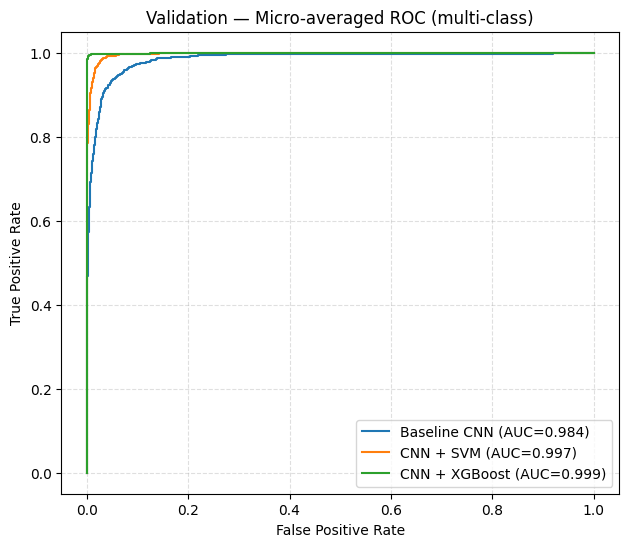

,Model,F1_micro VALUE,ROC_AUC_micro VALUE
2,CNN & XGBoost,0.983158,0.999045
1,CNN & SVM,0.894737,0.996988
0,Baseline CNN,0.801053,0.984265


In [11]:

fpr_cnn_v, tpr_cnn_v, auc_cnn_v = micro_roc_auc(y_T_Val, y_Prob_Val_Cnn, NUM_CLASSES)
fpr_svm_v, tpr_svm_v, auc_svm_v = micro_roc_auc(y_val, y_prob_val_svm, NUM_CLASSES)
fpr_xgb_v, tpr_xgb_v, auc_xgb_v = micro_roc_auc(y_val, y_prob_val_xgb, NUM_CLASSES)

plt.figure(figsize=(7.2,6))
plt.plot(fpr_cnn_v, tpr_cnn_v, label=f"Baseline CNN (AUC={auc_cnn_v:.3f})")
plt.plot(fpr_svm_v, tpr_svm_v, label=f"CNN + SVM (AUC={auc_svm_v:.3f})")
plt.plot(fpr_xgb_v, tpr_xgb_v, label=f"CNN + {xgb_name} (AUC={auc_xgb_v:.3f})")
# plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Validation — Micro-averaged ROC (multi-class)")
plt.legend(loc="lower right"); plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

display(pd.DataFrame({
    "Model": ["Baseline CNN", "CNN & SVM", f"CNN & {xgb_name}"],
    "F1_micro VALUE": [f1_Micro_Cnn_Val, f1_micro_svm_val, f1_micro_xgb_val],
    "ROC_AUC_micro VALUE": [auc_cnn_v, auc_svm_v, auc_xgb_v],
}).sort_values("F1_micro VALUE", ascending=False))


# Testing the Prediction on the test data set (unlabeled)

In [12]:
def load_unlabeled_images(folder: Path, img_size: int):
    files, imgs = [], []
    for p in sorted(folder.rglob("*.png")):
        if p.is_file():
            try:
                img = keras.utils.load_img(p, target_size=(img_size, img_size))
                arr = keras.utils.img_to_array(img)
                imgs.append(arr)
                files.append(p.name)
            except Exception as e:
                print(f"Skipping {p}: {e}")
    if not imgs:
        raise RuntimeError(f"No images found in {folder.resolve()}")
    return files, np.stack(imgs, 0).astype("float32")

TEST_DIR_PATH = Path(TEST_DIR)
files_test, Xtest = load_unlabeled_images(TEST_DIR_PATH, IMG_SIZE)
ds_unlab = tf.data.Dataset.from_tensor_slices(Xtest).batch(BATCH_SIZE).prefetch(AUTOTUNE)

prob_cnn_t = cnn.predict(ds_unlab, verbose=0)
pred_cnn_t = prob_cnn_t.argmax(1)
top_cnn_t = prob_cnn_t.max(1)

Ztest = feature_extractor.predict(ds_unlab, verbose=0)

prob_svm_t = svm_clf.predict_proba(Ztest)
pred_svm_t = prob_svm_t.argmax(1)
top_svm_t = prob_svm_t.max(1)

prob_xgb_t = xgb_clf.predict_proba(Ztest)
pred_xgb_t = prob_xgb_t.argmax(1)
top_xgb_t = prob_xgb_t.max(1)

model_tag = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"
pred_df = pd.DataFrame({
    "file": files_test,
    "CNN_pred": [CLASS_NAMES[i] for i in pred_cnn_t],
    "CNN_conf": top_cnn_t,
    "SVM_pred": [CLASS_NAMES[i] for i in pred_svm_t],
    "SVM_conf": top_svm_t,
    f"{model_tag}_pred": [CLASS_NAMES[i] for i in pred_xgb_t],
    f"{model_tag}_conf": top_xgb_t,
}).sort_values("file").reset_index(drop=True)


print(f"\nPredictions generated for {len(files_test)} images in ./test")
display(pred_df)



Predictions generated for 794 images in ./test


,file,CNN_pred,CNN_conf,SVM_pred,SVM_conf,XGBoost_pred,XGBoost_conf
0,0021e90e4.png,Small-flowered Cranesbill,0.804738,Small-flowered Cranesbill,0.980326,Small-flowered Cranesbill,0.998453
1,003d61042.png,Fat Hen,0.915945,Fat Hen,0.973131,Fat Hen,0.999081
2,007b3da8b.png,Cleavers,0.345865,Sugar beet,0.558493,Sugar beet,0.902264
3,0086a6340.png,Common Chickweed,0.986762,Common Chickweed,0.980906,Common Chickweed,0.999611
4,00c47e980.png,Sugar beet,0.699332,Sugar beet,0.920762,Sugar beet,0.997244
...,...,...,...,...,...,...,...
789,fea355851.png,Loose Silky-bent,0.883160,Loose Silky-bent,0.942476,Loose Silky-bent,0.999273
790,fea3da57c.png,Sugar beet,0.920001,Sugar beet,0.981073,Sugar beet,0.998965
791,fef2ade8c.png,Sugar beet,0.855534,Sugar beet,0.970390,Sugar beet,0.998302
792,ff65bc002.png,Charlock,0.862694,Charlock,0.993460,Charlock,0.998824


In [13]:
pred_df.describe()

,CNN_conf,SVM_conf,XGBoost_conf
count,794.000000,794.000000,794.000000
mean,0.750004,0.837988,0.923674
std,0.181952,0.167455,0.136748
min,0.255962,0.266627,0.271179
25%,0.608294,0.742173,0.914915
50%,0.792142,0.908509,0.993782
75%,0.903476,0.971582,0.998574
max,0.999220,0.996200,0.999780
